# <a id='toc1_'></a>[ARIMA](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [ARIMA](#toc1_)    
  - [Import Libraries](#toc1_1_)    
  - [Get Data](#toc1_2_)    
  - [ADF Test](#toc1_3_)    
  - [Diff data and remove outliers](#toc1_4_)    
  - [Test Stationarity again](#toc1_5_)    
  - [Show Distribution of data](#toc1_6_)    
  - [PACF & ACF plots](#toc1_7_)    
  - [Plot Diff Data](#toc1_8_)    
  - [White Noise Test for Analytical Value](#toc1_9_)    
- [Model Initialization](#toc2_)    
  - [Initaite the model](#toc2_1_)    
  - [Heat Map](#toc2_2_)    
  - [White Noise test for model residuals](#toc2_3_)    
  - [Random Walk and Prediction of the next value](#toc2_4_)    
  - [Plot Distribution of Residuals](#toc2_5_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Import Libraries](#toc0_)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tabulate import tabulate
import LSTMpy as lstm

## set random seed
np.random.seed(42)


## <a id='toc1_2_'></a>[Get Data](#toc0_)

In [3]:
## Get the data for the respective variable to model
column = "SEKDKK"

data = pd.read_csv("20_year_data.csv", delimiter=";")

data['Date'] = pd.to_datetime(data['Date'], format = '%d/%m/%Y')
data = data.set_index('Date')

data = data.replace(to_replace=",", value=".", regex=True)

## Convert all columns to float using regex
data = data.replace(to_replace="[^0-9.]", value="", regex=True)

## Convert all columns to numeric 
data = data.apply(pd.to_numeric)

## choose only the "Value" column with iloc
data = data.iloc[:, 2:3]

data


,Value
Date,
2003-05-02,0.8150
2003-05-05,0.8173
2003-05-06,0.8173
2003-05-07,0.8173
2003-05-08,0.8153
...,...
2023-04-25,0.6592
2023-04-26,0.6573
2023-04-27,0.6540


In [4]:
import os
if not os.path.exists(f"ARIMA {column}"):
    os.makedirs(f"ARIMA {column}")

# set the path the folder where the models are saved

pwd = os.getcwd()

path = pwd + f"/ARIMA {column}/"

print(path)

/Users/vg/Desktop/Model – BA/ARIMA SEKDKK/


## <a id='toc1_3_'></a>[ADF Test](#toc0_)

In [5]:
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value}")
    if result[1] > 0.05:
        print("The series is not stationary")
   
    else:
        print("The series is stationary")
    
    ## use tabulate to output the results in a latex table
    table = [["ADF Statistic", result[0]], ["p-value", result[1]]]
    for key, value in result[4].items():
        table.append([key, value])
    
    ## Add line to say if the series is stationary or not
    if result[1] > 0.05:
        table.append(["The series is not stationary as the p-value is greater than 0.05"])
    else:
        table.append(["The series is stationary as the p-value is less than 0.05"])
    
    print(tabulate(table, tablefmt="latex"))
    
    ## save the table a latex table to the path chosen above
    with open(f"ARIMA {column}_stationarity(before).tex", "w") as f:
        f.write(tabulate(table, tablefmt="latex"))
    

test_stationarity(data.values)

## save the table a latex table




ADF Statistic: -1.0748339567894727
p-value: 0.7250027978664912
Critical Values:
	1%: -3.4316595802782865
	5%: -2.8621186927706463
	10%: -2.567078038881065
The series is not stationary
\begin{tabular}{lr}
\hline
 ADF Statistic                                                    & -1.07483  \\
 p-value                                                          &  0.725003 \\
 1\%                                                               & -3.43166  \\
 5\%                                                               & -2.86212  \\
 10\%                                                              & -2.56708  \\
 The series is not stationary as the p-value is greater than 0.05 &           \\
\hline
\end{tabular}


## <a id='toc1_4_'></a>[Diff data and remove outliers](#toc0_)

In [6]:
# 1st order differencing to make the series stationary
diff_data = data.diff().dropna()

# Remove outliers
diff_data = diff_data[diff_data < 0.05]
diff_data = diff_data[diff_data > -0.05]

# table of the removed outliers
table = [["Removed outliers", len(data) - len(diff_data)], ["Total number of observations", len(data)]]
print(tabulate(table, tablefmt="latex"))

## save the table a latex table
with open(f"ARIMA {column}_outliers.tex", "w") as f:
    f.write(tabulate(table, tablefmt="latex"))


\begin{tabular}{lr}
\hline
 Removed outliers             &    1 \\
 Total number of observations & 5028 \\
\hline
\end{tabular}


## <a id='toc1_5_'></a>[Test Stationarity again](#toc0_)

In [7]:
test_stationarity(diff_data.values)

result = adfuller(diff_data.values)

table = [["ADF Statistic", result[0]], ["p-value", result[1]]]

    

## save the table a latex table
with open(f"ARIMA {column}_stationarity(after).tex", "w") as f:
    f.write(tabulate(table, tablefmt="latex"))

    



ADF Statistic: -13.666826369964042
p-value: 1.4852359341083196e-25
Critical Values:
	1%: -3.4316601050096995
	5%: -2.8621189245940792
	10%: -2.5670781622897416
The series is stationary
\begin{tabular}{lr}
\hline
 ADF Statistic                                             & -13.6668      \\
 p-value                                                   &   1.48524e-25 \\
 1\%                                                        &  -3.43166     \\
 5\%                                                        &  -2.86212     \\
 10\%                                                       &  -2.56708     \\
 The series is stationary as the p-value is less than 0.05 &               \\
\hline
\end{tabular}


## <a id='toc1_6_'></a>[Show Distribution of data](#toc0_)

(4817, 1)
(210, 1)


/var/folders/zn/8wl2ftxd7sg0pjvzvx59s5xr0000gn/T/ipykernel_93481/1110746547.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean = float(mean)
/var/folders/zn/8wl2ftxd7sg0pjvzvx59s5xr0000gn/T/ipykernel_93481/1110746547.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(diff_data, hist=True, kde=True, bins=30, color='b', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}, label = "True Distribution")


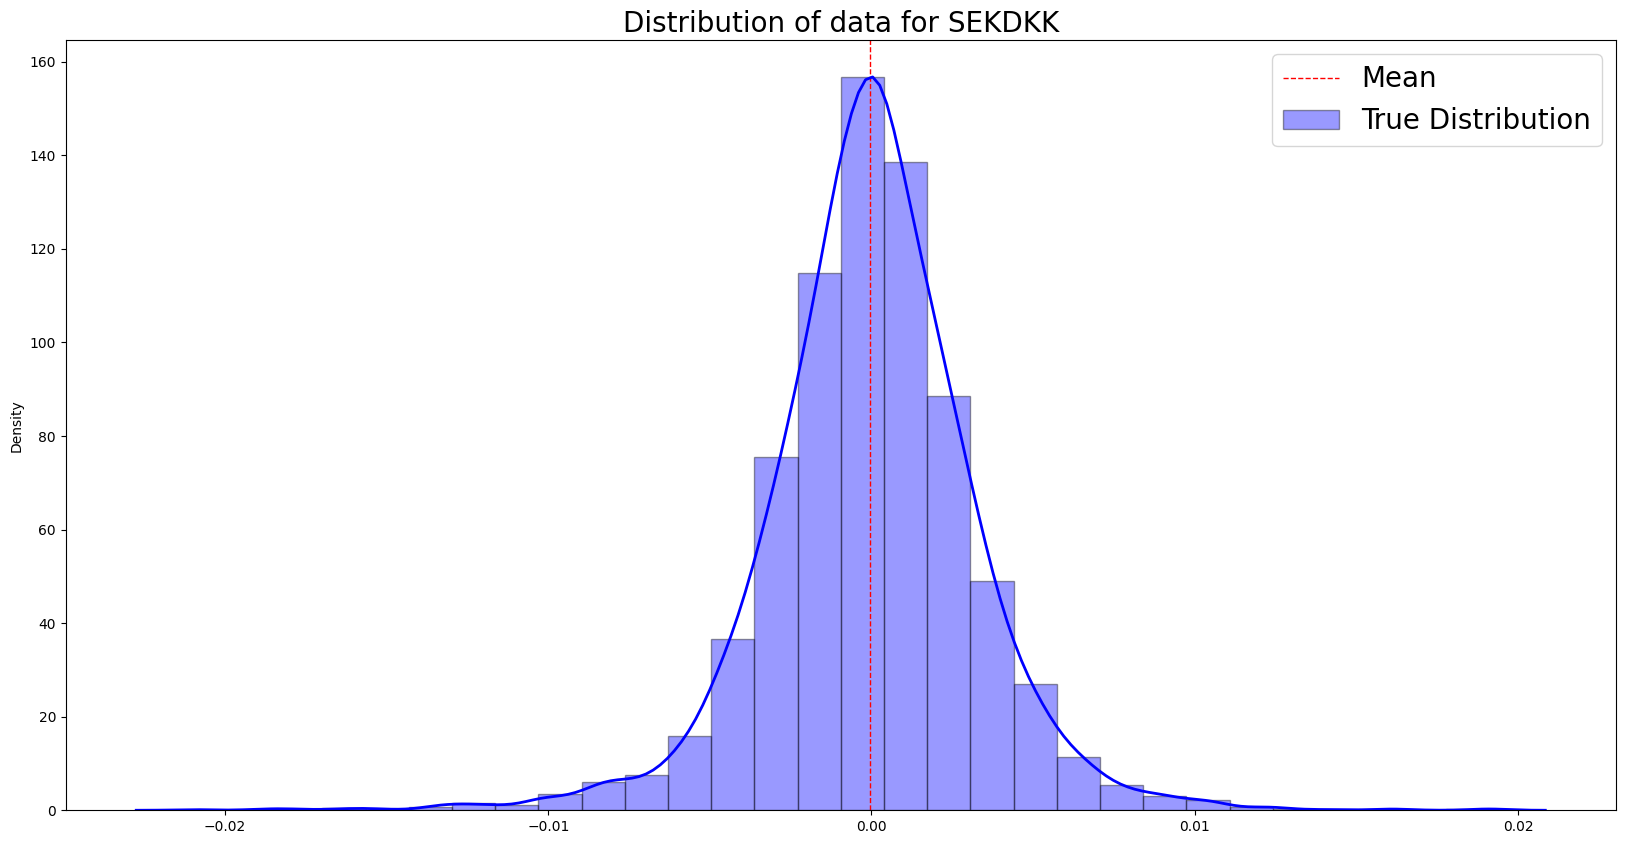

In [8]:
## Split into train and test
data_train = diff_data[:-210]
data_test = diff_data[-210:]

print(data_train.shape)
print(data_test.shape)

mean = diff_data.mean()
mean = float(mean)

# Plot distribution of data 
plt.figure(figsize=(20,10))
plt.title(f"Distribution of data for {column}", size = 20)

## add a vertical line at the mean
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label = "Mean")

## add legend to plot


## add true bell curve to the plot
sns.distplot(diff_data, hist=True, kde=True, bins=30, color='b', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}, label = "True Distribution")

plt.legend(fontsize = 20)

## Save fig to path
plt.savefig(f"ARIMA {column}_distribution.png")

plt.show()





## <a id='toc1_7_'></a>[PACF & ACF plots](#toc0_)


/Users/vg/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


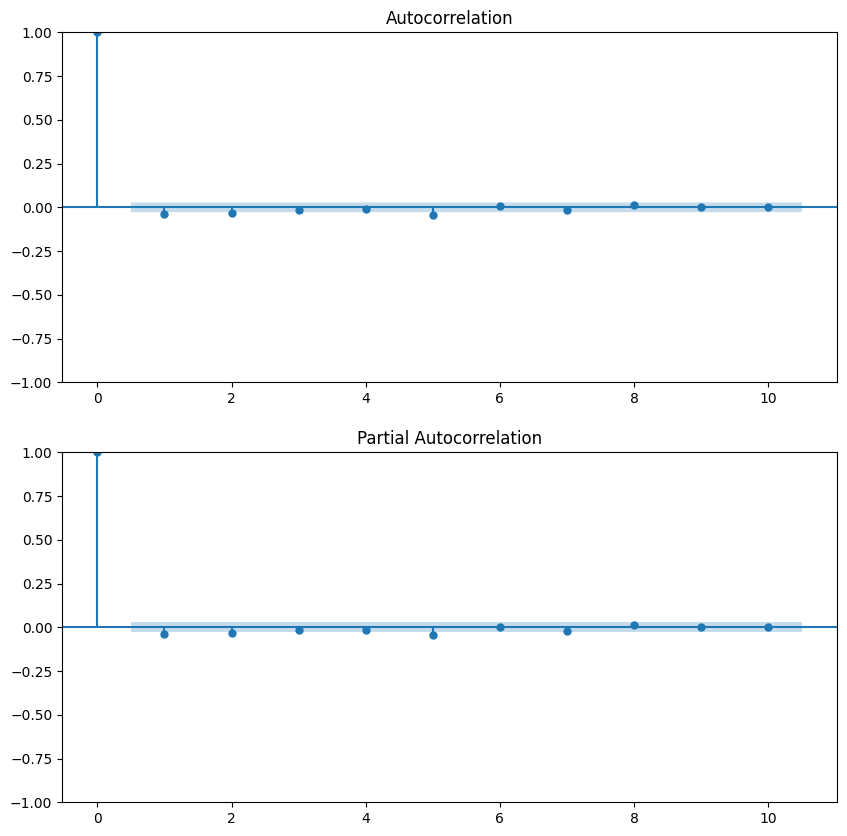

In [15]:
## plot acf and pacf in a 2x1 grid for the diff_data
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(diff_data.values.squeeze(), lags=10, ax=plt.gca())
plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(diff_data.values.squeeze(), lags=10, ax=plt.gca())

## Save fig to path
plt.savefig(f"ARIMA {column}_acf_pacf.png")

plt.show()

## <a id='toc1_8_'></a>[Plot Diff Data](#toc0_)

/var/folders/zn/8wl2ftxd7sg0pjvzvx59s5xr0000gn/T/ipykernel_85454/3312857007.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  mean = float(mean)


-3.105231748557786e-05


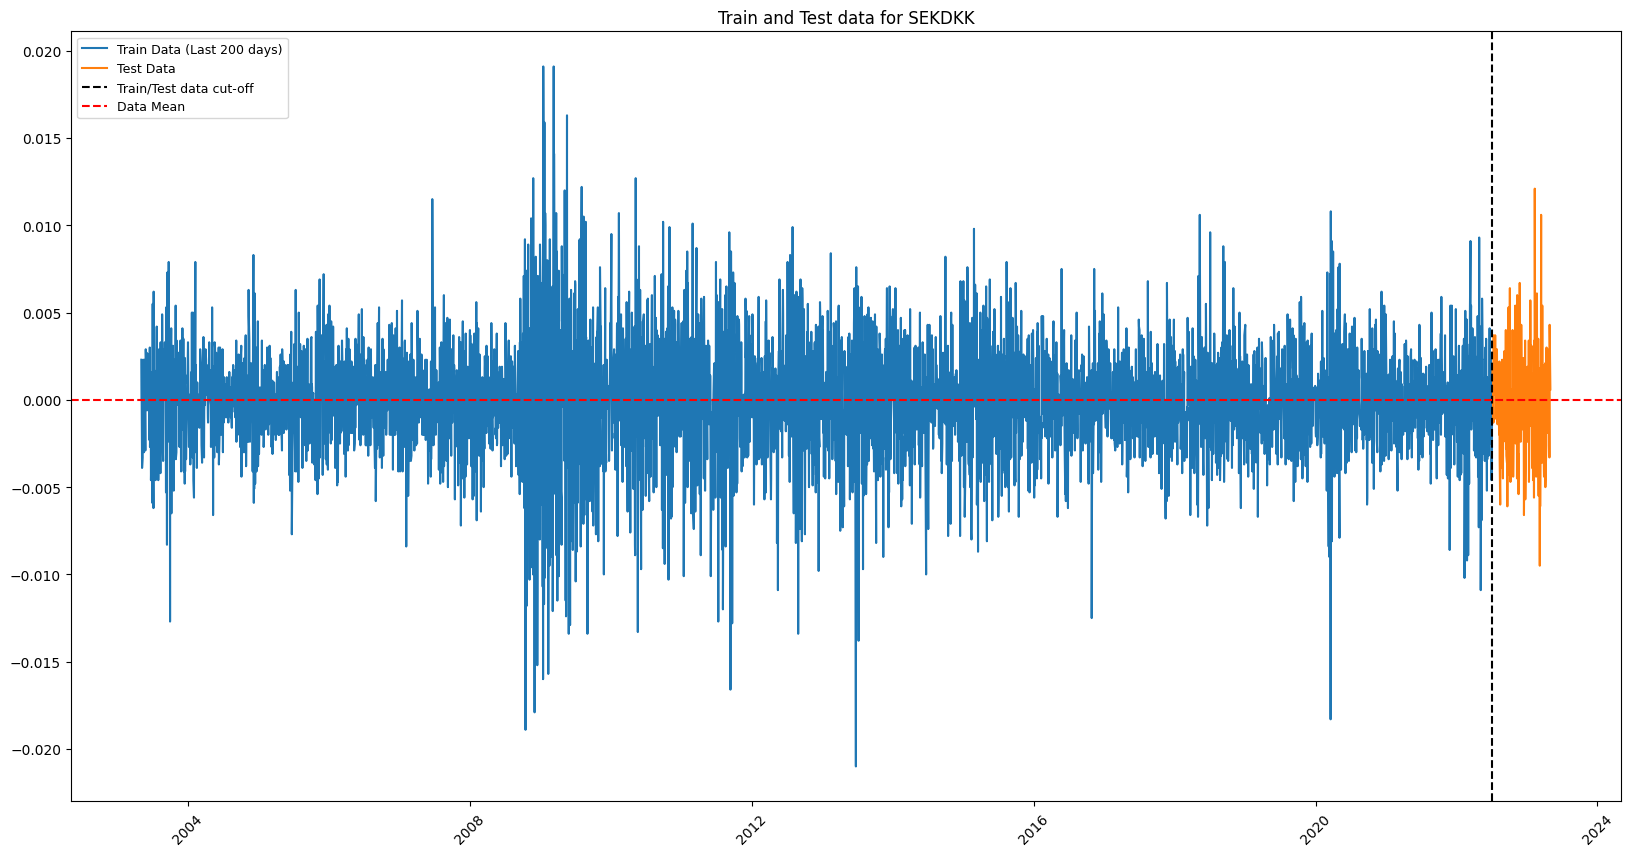

In [16]:
## plot the data
plt.figure(figsize=(20, 10))
plt.plot(data_train, label = 'Train Data (Last 200 days)')
plt.plot(data_test, label = 'Test Data')
plt.title('Train (Only 200 days) and Test data')
plt.axvline(x=data_train.index[-1],color='black', linestyle='--', label = 'Train/Test data cut-off')
plt.xticks(rotation=45)
plt.title(f'Train and Test data for {column}')

## plot mean as a horizontal line

mean = diff_data.mean()
mean = float(mean)
print(mean)

plt.axhline(mean, color='r', linestyle='--', label = 'Data Mean')
plt.legend(loc='best', fontsize = 9)

plt.savefig(f"ARIMA {column}_train_test.png")

plt.show()

## <a id='toc1_9_'></a>[White Noise Test for Analytical Value](#toc0_)

In [17]:
## White Noise Test for the data
from statsmodels.stats.diagnostic import acorr_ljungbox

## run the test


sm.stats.acorr_ljungbox(data, lags=[1], return_df=True)

def white_noise(data, lags, name=''):
    """ 
    Function to test if the data is white noise
    """
    ## run the test
    test_results = sm.stats.acorr_ljungbox(data, lags=[lags], return_df=True)
    
    ## extract the p-value from the test results
    p_value = test_results.iloc[0,1]
    
    ## print the results
    print(f"The p-value from the white noise test is {p_value}")
    
    if p_value < 0.05:
        print("The data is not white noise")
    else:
        print("The data is white noise")
        
    ## Output the test in a latex table using tabulate
    table = [["Lag", "p-value"], [lags, p_value]]
    print(tabulate(table, tablefmt="latex", headers = name))

    
    
    ## return the p-value
    return p_value


## run the function
white_noise(data, 1, ["Lags", "P-Value Data"])

table = [["Lags", "P-Value Data"], [1, white_noise(data, 1)]]
name = ["Lags", "P-Value Data"]

## save the table a latex table
with open(f"ARIMA {column}_white_noise(before).tex", "w") as f:
    f.write(tabulate(table, tablefmt="latex", headers = name))
    


The p-value from the white noise test is 0.0
The data is not white noise
\begin{tabular}{ll}
\hline
 Lags   & P-Value Data   \\
\hline
 Lag    & p-value        \\
 1      & 0.0            \\
\hline
\end{tabular}
The p-value from the white noise test is 0.0
The data is not white noise
\begin{tabular}{ll}
\hline
 Lag & p-value \\
 1   & 0.0     \\
\hline
\end{tabular}


# <a id='toc2_'></a>[Model Initialization](#toc0_)

## <a id='toc2_1_'></a>[Initaite the model](#toc0_)

def fit_auto_arima(data):
    model = auto_arima(data, seasonal=False, stepwise=False,
                       suppress_warnings=True,
                       error_action='ignore',
                       max_p=10, 
                       max_d=10, 
                       max_q=10, 
                       trace=True)
    return model


model = fit_auto_arima(diff_data)
print(model.summary())

In [18]:
## Create Heatmap for AIC values for different p and q values
# supress warnings
import warnings
import tqdm as tqdm

## Use wls for weighted least squares
aic_matrix = np.zeros((10,10))
warnings.filterwarnings("ignore")


## Loop through all the p and q values and fit the model and use progress bar to show progress from tqdm
for p in tqdm.tqdm(range(10)):
    for q in range(10):
        try:
            model = sm.tsa.ARIMA(diff_data, order=(p,1,q)).fit()
            aic_matrix[p,q] = model.aic
        except:
            pass




100%|██████████| 10/10 [04:38<00:00, 27.88s/it]


## <a id='toc2_2_'></a>[Heat Map](#toc0_)

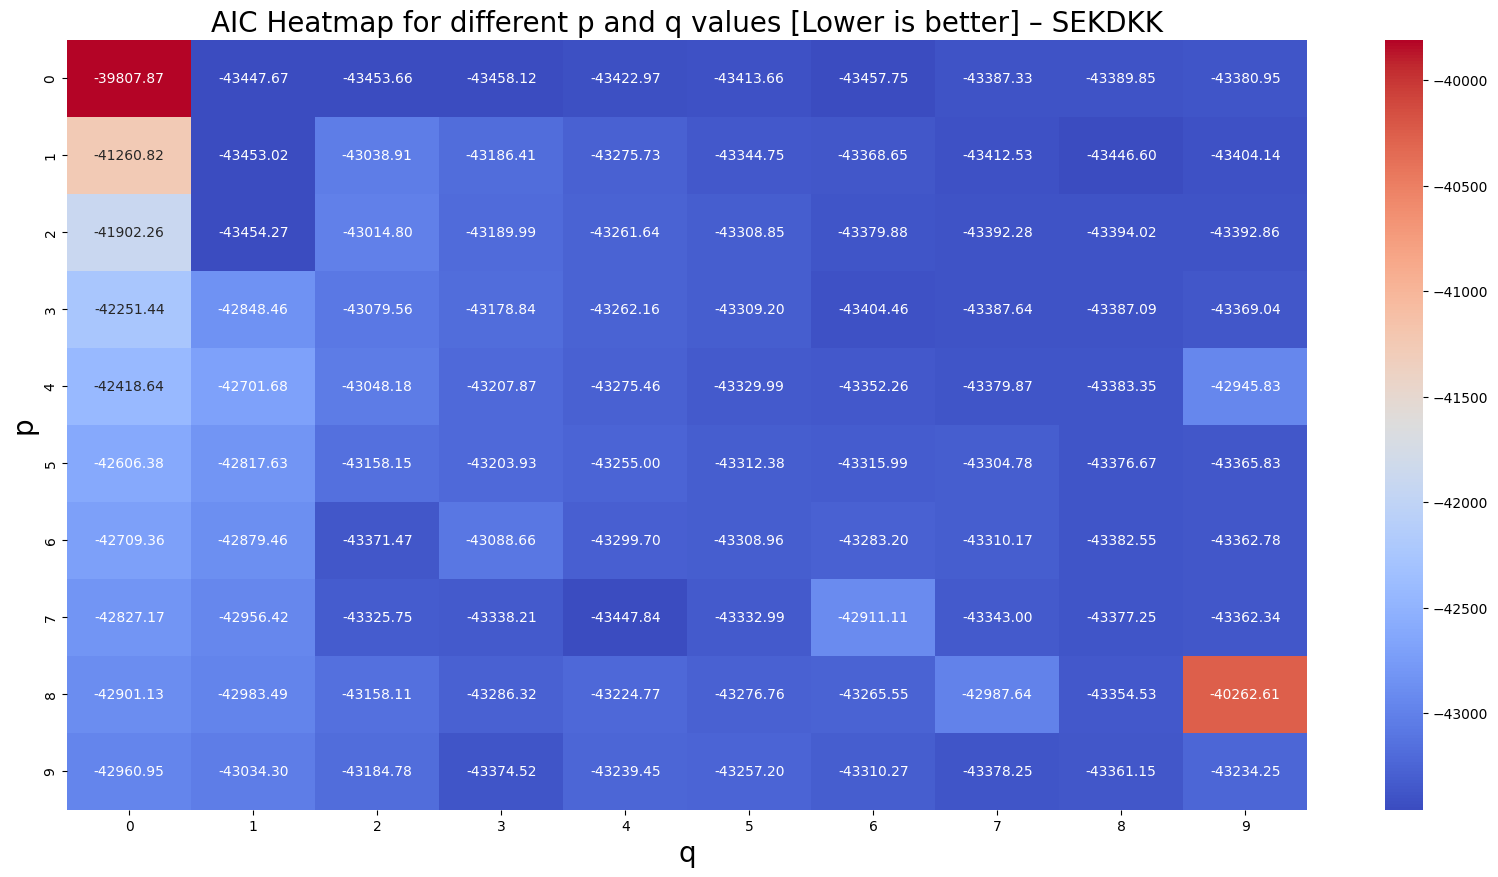

The best p and q values are
(array([0]), array([3]))


In [19]:
## Plot the heatmap for the AIC values for different p and q values
# change size to 20 X 10 inches
plt.figure(figsize=(20,10))

## make heat map only show the 10 best AIC values
sns.heatmap(aic_matrix, mask=(aic_matrix==0), annot=True, fmt='.2f', cmap = 'coolwarm')
plt.title(f'AIC Heatmap for different p and q values [Lower is better] – {column}', size = 20 )
plt.xlabel('q', size = 20)
plt.ylabel('p', size = 20)

## Save fig to path
plt.savefig(f"ARIMA {column}_aic_heatmap.png")

plt.show()

print("The best p and q values are")
print(np.where(aic_matrix == np.min(aic_matrix)))

## print serperate values for p and q for the best model



In [9]:
## model summary for the best model which draws from the heatmap
# get p and q value for the best model
#p = aic_matrix.argmin()//10
#q = aic_matrix.argmin()%10

p = 0
q = 3

print(f"The best p and q values are {p} and {q} respectively")


model = sm.tsa.ARIMA(diff_data, order=(p,1,q)).fit()
print(model.summary())

# print summary in latex
print(model.summary().as_latex())

The best p and q values are 0 and 3 respectively


/Users/vg/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vg/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/vg/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                 5027
Model:                 ARIMA(0, 1, 3)   Log Likelihood               21733.061
Date:                Wed, 03 May 2023   AIC                         -43458.123
Time:                        15:21:00   BIC                         -43432.033
Sample:                             0   HQIC                        -43448.981
                               - 5027                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0396      0.012    -88.336      0.000      -1.063      -1.017
ma.L2          0.0029      0.015      0.201      0.840      -0.026       0.032
ma.L3          0.0384      0.010      3.817      0.0

/Users/vg/opt/anaconda3/envs/ml/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## <a id='toc2_3_'></a>[White Noise test for model residuals](#toc0_)

In [1]:
## find residuals for the model
residuals = model.resid
print(residuals)

## white noise test for the residuals
white_noise(residuals, 1, ["Lags", "P-Value Residuals"])

table = [["Lags", "P-Value Residuals"], [1, white_noise(residuals, 1)]]
name = ["Lags", "P-Value Residuals"]

## save the table a latex table
with open(f"ARIMA {column}_white_noise(after).tex", "w") as f:
    f.write(tabulate(table, tablefmt="latex", headers = name))




NameError: name 'model' is not defined

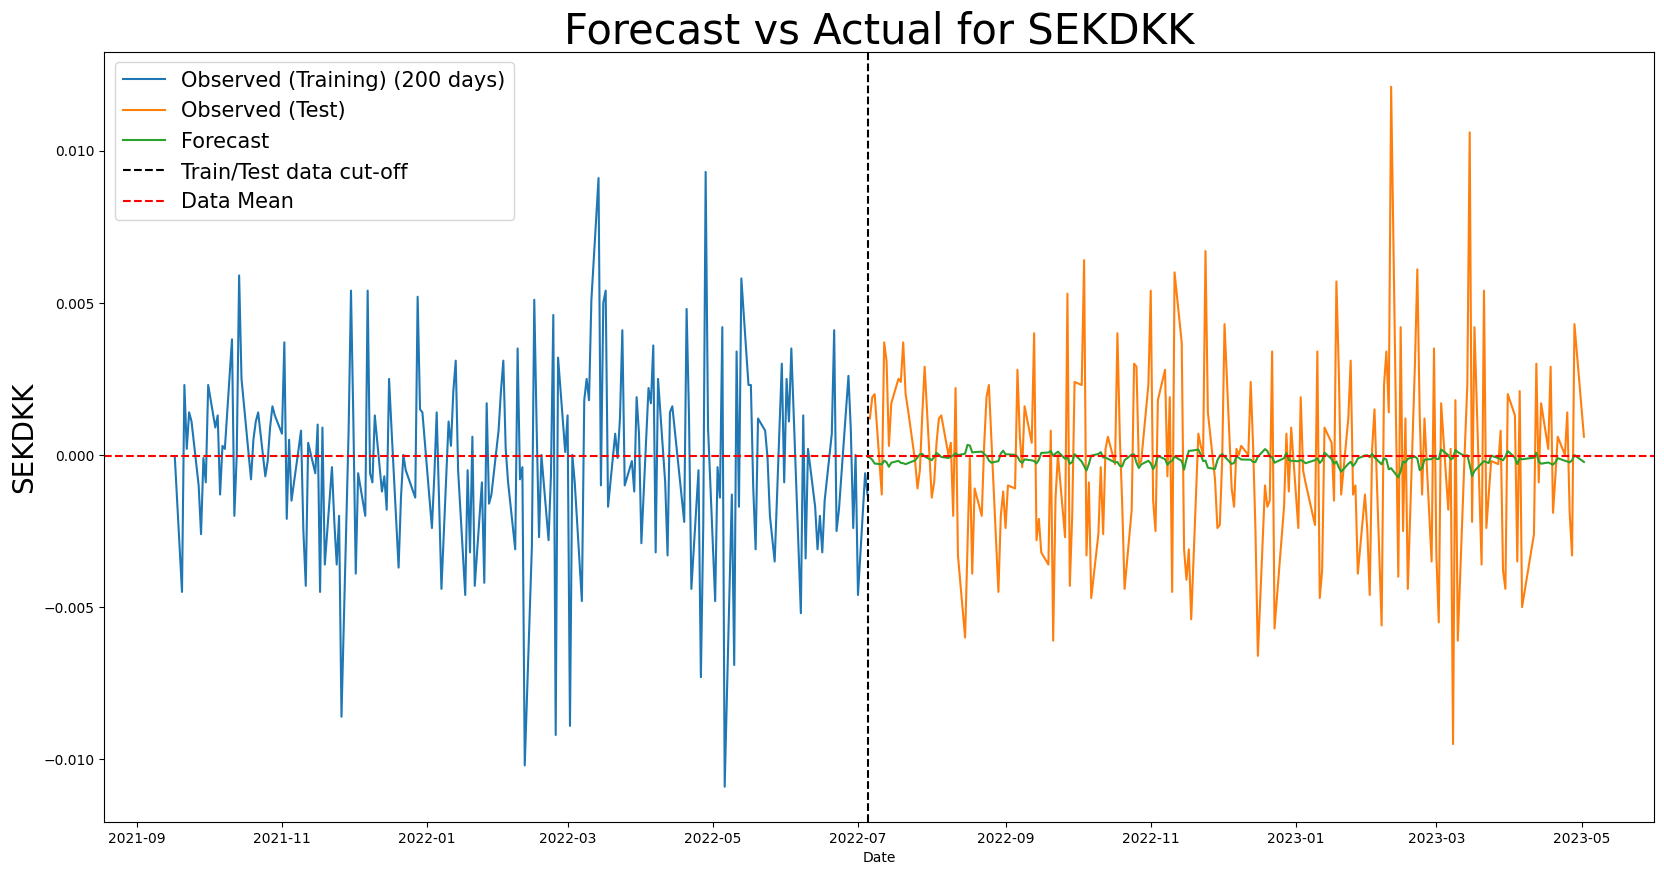

In [11]:
## Plot the 30-day forecast and compare it to the actual values
def plot_forecast_comparison(model, y_train, y_test, steps=210):
    forecast = model.predict(n_periods=steps)
    forecast = pd.Series(forecast, index=y_test.index)
    
    plt.figure(figsize=(20, 10))
    plt.plot(y_train[-200:], label='Observed (Training) (200 days)')
    plt.plot(y_test, label='Observed (Test)')
    plt.plot(forecast, label='Forecast')
    plt.axvline(x=y_train.index[-1],color='black', linestyle='--', label = 'Train/Test data cut-off')
    plt.title(f'Forecast vs Actual for {column}', size = 30)
    plt.axhline(mean, color='r', linestyle='--', label = 'Data Mean')
    plt.xlabel('Date')
    plt.ylabel('SEKDKK', size = 20)
    plt.legend(fontsize = 15)
    
    ## save fig to path
    plt.savefig(f"ARIMA {column}_forecast.png")
    
    
    plt.show()
    

plot_forecast_comparison(model, data_train, data_test)

In [12]:
# Get model metrics, R^2, MSE, MAE, MAPE, RMSE for the forecast and the test data
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def get_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    ## output in a latex table
    table = [["R2", r2], ["MSE", mse], ["MAE", mae], ["MAPE", mape], ["RMSE", rmse]]
    print(tabulate(table, tablefmt="latex"))
    
    
    
    return table

## Get the metrics for the forecast

forecast = model.predict(n_periods=210)
forecast = pd.Series(forecast, index=data_test.index)
test = diff_data[-210:]


get_metrics(test, forecast)


## Save table to latex with, title headers and name
table = get_metrics(test, forecast)
name = ["Metric", "Value"]

with open(f"ARIMA {column}_metrics_forecast.tex", "w") as f:
    f.write(tabulate(table, tablefmt="latex", headers = name))
    






\begin{tabular}{lr}
\hline
 R2   & -0.0148222   \\
 MSE  &  9.35755e-06 \\
 MAE  &  0.00236452  \\
 MAPE &  1.80592e+10 \\
 RMSE &  0.00305901  \\
\hline
\end{tabular}
\begin{tabular}{lr}
\hline
 R2   & -0.0148222   \\
 MSE  &  9.35755e-06 \\
 MAE  &  0.00236452  \\
 MAPE &  1.80592e+10 \\
 RMSE &  0.00305901  \\
\hline
\end{tabular}


## <a id='toc2_4_'></a>[Random Walk and Prediction of the next value](#toc0_)

In [23]:
## Define counter for the number of times the model predicts the correct direction of the exchange rate
counter = 0
counter_random = 0

# initiate random walk for comparison
correct_direction_random = 0
false_direction_random = 0

# initiate model direction counter
correct_direction = 0
false_direction = 0

## initiate random walk for comparison
# set seed
np.random.seed(42)

forecast = model.predict(n_periods=210)
forecast = pd.Series(forecast, index=data_test.index)

# create random walk with forecast as index
random_walk = np.cumsum(np.random.normal(0, 1, len(forecast - 1)))

# set index for random walk to be the same as the forecast
random_walk = pd.Series(random_walk, index=forecast.index)


# create a data frame with forecast, random walk and actual values
## create a data frame with forecast, random walk and actual values
df = pd.DataFrame({'forecast': forecast, 'random_walk': random_walk, 'actual': data_test.squeeze()})


## create loop to check if the forecast predicts the correct direction of the exchange rate when compared to the actual values
for i in range((len(forecast) - 1)):
    if df['forecast'][i] > df['forecast'][i-1] and df['actual'][i] > df['actual'][i-1]:
        counter += 1
        correct_direction += 1
    elif df['forecast'][i] < df['forecast'][i-1] and df['actual'][i] < df['actual'][i-1]:
        counter += 1
        correct_direction += 1
    else:
        counter -= 1
        false_direction += 1
        
    if df['random_walk'][i] > df['random_walk'][i-1] and df['actual'][i] > df['actual'][i-1]:
        counter_random += 1
        correct_direction_random += 1
    elif df['random_walk'][i] < df['random_walk'][i-1] and df['actual'][i] < df['actual'][i-1]:
        counter_random += 1
        correct_direction_random += 1
    else:
        counter_random -= 1
        false_direction_random += 1


## create latex table for the number of times the model predicts the correct direction of the exchange rate
table_model = [["Counter", counter],
            ["Total number of predictions", len(forecast)],
            ["Number of correct directions", correct_direction],
            ["Number of false directions", false_direction],
            ["Percentage of correct directions", correct_direction / len(forecast)],
            ["Percentage of false directions", false_direction / len(forecast)]]

#print(tabulate(table_model, tablefmt="latex"))

table_random = [["Counter", counter_random],
            ["Total number of predictions", len(forecast)],
            ["Number of correct directions", correct_direction_random],
            ["Number of false directions", false_direction_random],
            ["Percentage of correct directions", correct_direction_random / len(forecast)],
            ["Percentage of false directions", false_direction_random / len(forecast)]]

#print(tabulate(table_random, tablefmt="latex"))

## a table which includes direction metrics for the random walk and the model with titles for random walk and model

pct_correct_arima = (correct_direction / (len((forecast) - 1)))
pct_correct_random = (correct_direction_random / (len((forecast) - 1)))
pct_wrong_arima = 1 - pct_correct_arima
pct_wrong_random = 1 - pct_correct_random


table_concat = [
            ["Total number of predictions", len(forecast) - 1,  len(forecast) - 1],
            ["Number of correct directions", correct_direction, correct_direction_random],
            ["Number of false directions", false_direction, false_direction_random],
            ["Percentage of correct directions", "{:.2%}".format(pct_correct_arima), "{:.2%}".format(pct_correct_random)],
            ["Percentage of false directions", "{:.2%}".format(pct_wrong_arima), "{:.2%}".format(pct_wrong_random)]]

print(tabulate(table_concat, tablefmt="latex", headers=[f"ARIMA {column}", "Random walk"]))
          

## save table to latex with, title headers and name
name = [f"ARIMA {column}", "Random walk"]

with open(f"ARIMA {column}_direction.tex", "w") as f:
    f.write(tabulate(table_concat, tablefmt="latex", headers = name))
    



\begin{tabular}{lll}
\hline
                                  & ARIMA SEKDKK   & Random walk   \\
\hline
 Total number of predictions      & 209            & 209           \\
 Number of correct directions     & 145            & 103           \\
 Number of false directions       & 64             & 106           \\
 Percentage of correct directions & 69.05\%         & 49.05\%        \\
 Percentage of false directions   & 30.95\%         & 50.95\%        \\
\hline
\end{tabular}


## <a id='toc2_5_'></a>[Plot Distribution of Residuals](#toc0_)

/var/folders/zn/8wl2ftxd7sg0pjvzvx59s5xr0000gn/T/ipykernel_93481/2088596133.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residuals, hist=True, kde=True, bins=30, color='b', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}, label = "True Distribution")


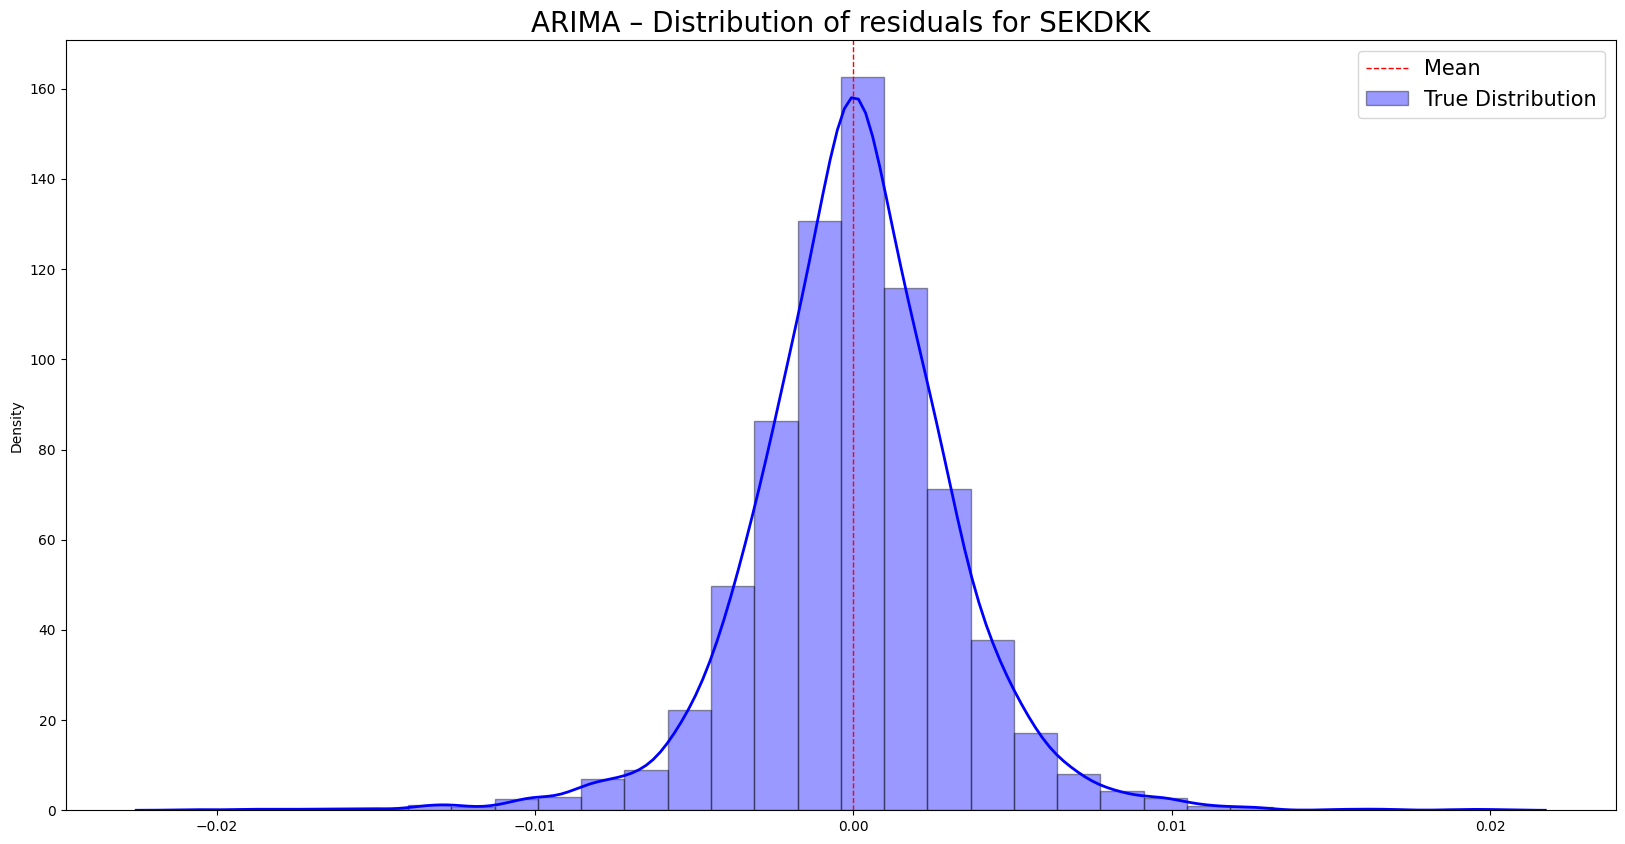

In [17]:

## Find mean of the residuals
mean = residuals.mean()
mean = float(mean)

# Plot distribution of data 
plt.figure(figsize=(20,10))
plt.title(f"ARIMA – Distribution of residuals for {column}", size = 20)

## add a vertical line at the mean
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label = "Mean")

## add true bell curve to the plot
sns.distplot(residuals, hist=True, kde=True, bins=30, color='b', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 2}, label = "True Distribution")

plt.legend(fontsize = 15)

# save plot
plt.savefig(f"ARIMA {column}_residuals.png")

plt.show()
